In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.8


env: XLA_PYTHON_CLIENT_MEM_FRACTION=.8


In [3]:
import jax
jax.devices()

[cuda(id=0)]

In [4]:
import jax
import time
import equinox as eqx
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp
from IPython.display import clear_output
from jax import Array
from openmm import unit
import optax
from flow_diagrams.utils.conditioning import convert_from_reduced_p, convert_from_reduced_t
from matplotlib import colors



/srv/data/schebem94/miniconda3/envs/rigid_flows/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
jax.devices()

[cuda(id=0)]

In [6]:
from jax_md import space, partition
from jax_md.energy import lennard_jones

In [7]:
from flow_diagrams.utils.train import log_weights_given_latent, normalize_weights, sampling_efficiency, effective_sample_size, delta_f_to_prior, log_weights_given_latent_triple
from flow_diagrams.utils.visualization import radial_distribution_function
from flow_diagrams.utils.data import NumpyLoader, split_data
from flow_diagrams.utils.symmetry import *

from jax import numpy as jnp

from flow_diagrams.energy.lennard_jones import my_lennard_jones_neighbor_list

from flow_diagrams.models.coupling_flows import ConditionalCouplingFlowNPT
from flow_diagrams.models.coupling_layers import ConditionalCouplingLayerNPT

from flow_diagrams.utils.train import running_average
# from flow_diagrams.utils.lattice import volume_to_box
from flow_diagrams.utils.weights import get_weights, get_biases
from flow_diagrams.utils.jax import key_chain
from flow_diagrams.train.train import batch_loss, sample_loss#, make_step, batch_loss_temp_press_individual, batch_loss_temp_press_vmap
from IPython.display import clear_output
from flow_diagrams.utils.conditioning import grid_conditional_variables, random_conditional_variables
import time


2024-04-30 15:00:49.532707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-30 15:00:49.532756: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-30 15:00:49.532760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [8]:
chain = key_chain(1)

## Constants

In [9]:
LATTICE = 'fcc'
NUM_PARTICLES = 180
SPATIAL_DIMENSIONS = 3
REDUCED_CUTOFF = 2.2

KB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

SPATIAL_DIMENSIONS = 3

EPSILON = 0.995792 # in kJ / mol
# EPSILON = 1
SIGMA = 0.34 # in nm as used in openmm


## Transformation functions

In [10]:

def remove_disp_of_first_atom(displacements):
    # assert displacements.shape == (NUM_PARTICLES, SPATIAL_DIMENSIONS)

    disp_at_1 = displacements[0,:]

    return displacements - disp_at_1


def transform_abs_coords_to_rel_coords(absolute_coordinates: Array, side_length: Array):
    """Transforms relative coordinates inside the unit cube to absolute coordinates given a 3d box_vector."""
    assert absolute_coordinates.shape[-1] == SPATIAL_DIMENSIONS
    assert side_length.shape == (3,)
    return absolute_coordinates / side_length






## Put MD data into dataloader 

In [11]:
def wrap_to_unit_cube(pos, lower, upper):
    width = upper - lower
    return jnp.mod(pos - lower, width) + lower

def wrap_to_box(pos, box):
    return pos % box

In [12]:
jax.config.update("jax_enable_x64", False)


In [13]:
LOWER = 0.
UPPER = 1.
CUT_TYPE = 'switch'
REDUCED_TEMP_PRIOR = 1.2
TEMP_PRIOR = (REDUCED_TEMP_PRIOR * EPSILON / KB) 

REDUCED_PRESS_PRIOR = 8.5555

PRIOR_PRESSURE = REDUCED_PRESS_PRIOR * EPSILON / SIGMA **3

TEMP_PRIOR = (REDUCED_TEMP_PRIOR * EPSILON / KB) 

filename_prior = f"N{NUM_PARTICLES}-T{REDUCED_TEMP_PRIOR:.4f}-P{REDUCED_PRESS_PRIOR:.3f}-RCUT{REDUCED_CUTOFF:.2f}_20000.npz"

data_prior = jnp.load(filename_prior)
positions_prior_abs = data_prior['pos']
box_prior = data_prior['box']
vols_prior = jnp.prod(box_prior,axis=-1)
BOX_EDGES = np.mean(box_prior,axis=0)

# fix first atom in origin and wrap to box
positions_prior = jax.vmap(wrap_to_box)(jax.vmap(remove_disp_of_first_atom)(positions_prior_abs),box_prior)
MEAN_CONFIG = np.mean(positions_prior,axis=0)

# scale to [0,1]
positions_prior= jax.vmap(transform_abs_coords_to_rel_coords)(positions_prior,box_prior)
positions_prior = wrap_to_unit_cube(positions_prior,LOWER,UPPER)    

scale_prior = box_prior[:,0] / BOX_EDGES[0]
energies_prior = data_prior['ene']

assert np.logical_and(1. >= UPPER, positions_prior >= LOWER).all()
assert np.allclose(positions_prior[:,0,:],0,atol=1e-7)

n_configurations_prior = positions_prior.shape[0] 

print('# Prior samples', n_configurations_prior)

# Prior samples 20000


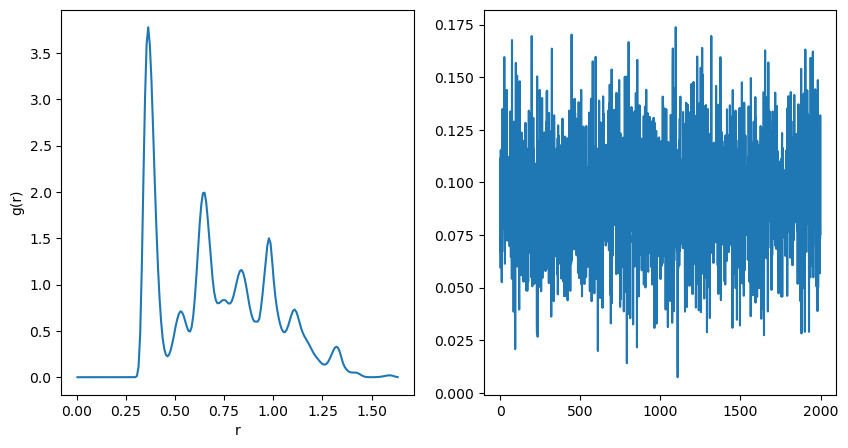

In [14]:
n_samples_rdf = 2000
rdf = radial_distribution_function(data_prior['pos'][:n_samples_rdf],data_prior['box'][:n_samples_rdf], NUM_PARTICLES)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(*rdf)
plt.ylabel('g(r)')
plt.xlabel('r')
plt.subplot(1,2,2)
plt.plot(data_prior['pos'][:n_samples_rdf,0,0])
plt.show()

In [15]:
BATCH_SIZE = 128


In [16]:
train_fraction = .8
# Store all displacements relative to first one (which stays at its equilibrium position)
dataset_prior_train, dataset_prior_test = split_data(train_fraction, positions_prior,
                        energies_prior,
                       scale_prior)
dataloader_train = NumpyLoader(dataset_prior_train,BATCH_SIZE,False)



In [17]:
len(dataset_prior_train), len(dataset_prior_test)

(16000, 4000)

## Prepare the system

In [18]:

# Using float32 for positions / velocities, but float64 for reductions.
dtype = np.float32

# Specify the format of the neighbor list. 
# Options are Dense, Sparse, or OrderedSparse. 
format = partition.OrderedSparse

In [19]:
displacement_frac, shift_frac = space.periodic_general(BOX_EDGES, fractional_coordinates=False)
neighbor_fn, energy_fn = my_lennard_jones_neighbor_list(
    displacement_frac,box_size=BOX_EDGES,
    r_onset=.9*REDUCED_CUTOFF, # in units of SIGMA
    r_cutoff = REDUCED_CUTOFF, # in units of SIGMA
    dr_threshold=1.,
    epsilon=EPSILON,
    sigma=SIGMA,
    shift=False,
    smooth=True,
    format=format,
    fractional_coordinates=False)
NEIGHBOR_LIST = neighbor_fn.allocate(MEAN_CONFIG)



In [20]:
def compute_lj_energy(pos_rel: jnp.ndarray, scale):
    box= scale * BOX_EDGES
    nbrs = NEIGHBOR_LIST.update(pos_rel * box)
    lj_energy = energy_fn(pos_rel * box, nbrs, box=box)

    return lj_energy


In [21]:
num_samples = 100


In [22]:
ene_prior = dataset_prior_test.energies[:num_samples]
pos_latent = dataset_prior_test.pos[:num_samples]
scale_latent = dataset_prior_test.scale[:num_samples]
# config_latent = jax.vmap(transform_abs_pos_to_abs_config)(pos_latent)
energies_recomputed_prior = jax.vmap(
               compute_lj_energy)(pos_latent,scale_latent)

/srv/data/schebem94/miniconda3/envs/rigid_flows/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:212: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


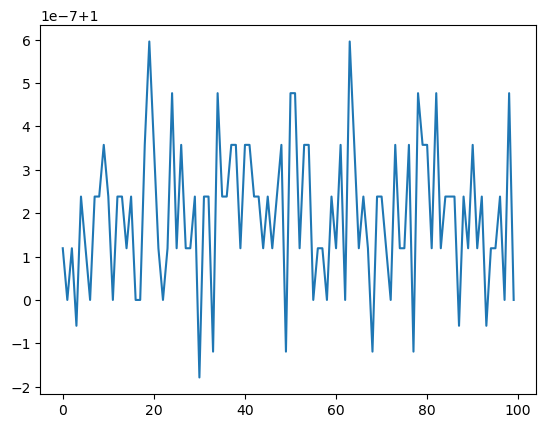

In [23]:
# Ensure that energy function reproduces the MD energies
plt.plot(ene_prior / energies_recomputed_prior)
plt.show()

In [24]:
chain=key_chain(1)

In [25]:
p_max = 20* convert_from_reduced_p(EPSILON, SIGMA)
p_min = 4* convert_from_reduced_p(EPSILON, SIGMA)

t_max = 1.6* convert_from_reduced_t(EPSILON, KB)
t_min = 0.6* convert_from_reduced_t(EPSILON, KB)
conditioning_states= grid_conditional_variables(t_min,t_max,p_min, p_max, 80,80)



In [26]:
assert conditioning_states[0,0] == t_min
assert conditioning_states[0,1] == p_min

assert conditioning_states[-1,0] == t_max
assert conditioning_states[-1,1] == p_max

In [27]:


flow = ConditionalCouplingFlowNPT(n_layers=1,
                            num_hidden=2,
                            dim_hidden=32,
                            num_hidden_shape=4,
                            dim_hidden_shape=16,
                            dim_embedd =32,
                            lower=0,
                            upper=1,
                            n_bins=16,
                            n_heads=1,
                            t_max=t_max,
                            p_max=p_max,
                            use_layer_norm=True,
                            n_blocks=1,
                            use_circular_shift=True,
                            n_freqs=8,
                            init_identity=True,
                            n_particles=NUM_PARTICLES ,
                            key= next(chain))

params, static = eqx.partition(flow, eqx.is_array)

param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"{param_count:_}")

246_955


## Train model

In [28]:
NUM_EPOCHS = 50
n_batches = len(dataloader_train)
n_total_steps = NUM_EPOCHS * n_batches


In [29]:
# optim = optax.adam(1e-7)
optim = optax.adam(1e-4
                   )
optim = optax.chain(optax.clip_by_global_norm(1e4), optim)

In [30]:
params, static = eqx.partition(flow, eqx.is_array)
opt_state = optim.init(params)


In [31]:
key = key_chain(1)


In [32]:
loss_batch_eval = jnp.zeros((n_batches,))
losses_eval = jnp.empty(shape=(0,))
efficiencies = jnp.empty(shape=(0,))


In [33]:
from flow_diagrams.train.train import make_step, batch_loss_temp_press_vmap, batch_loss_temp_press_individual

In [34]:
dataset_prior_test.scale


array([1.00385925, 1.00225627, 0.99632569, ..., 1.00167096, 0.99668435,
       1.00286451])

In [35]:
# dataset_prior_test.scale
# array([0.9977815 , 0.99377756, 0.99739725, ..., 1.00286451, 1.00269894,
#        0.99838047])

In [36]:
@eqx.filter_jit
def evaluate_flow(flow,pos,scale,temp,press):
    return flow.forward(pos=pos,scale=scale,temp=temp,press=press)

In [37]:
test = []

In [38]:
eval_state = jnp.array([[1.3 * EPSILON / KB, 8.5555 * EPSILON / SIGMA**3]])


In [39]:
# Reference value: Free energy difference per particle for evaluation state
delta_f_ref = -0.1391

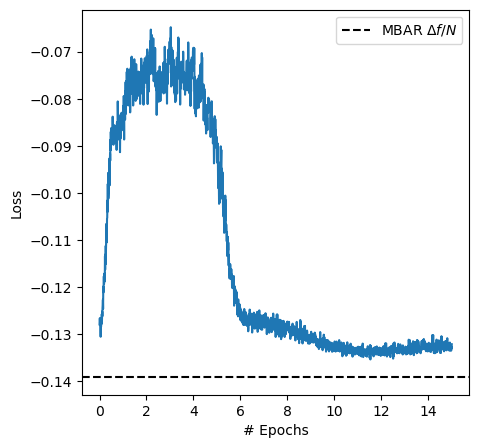

KeyboardInterrupt: 

In [40]:
PRINT_ITERS = 5
IS_LIQUID = False
for i in range(20):

    for ibatch, (batch_pos, batch_ene, batch_scale) in enumerate(dataloader_train):
        key = next(chain)
        chain = key_chain(key)

        loss_train, flow, opt_state = make_step(
            batch_pos=batch_pos,
            batch_ene=batch_ene,
            batch_scale=batch_scale,
            flow=flow,
            temps_and_pressures=conditioning_states,
            optimized_state=opt_state,
            optim=optim,
            target_energy_fn=compute_lj_energy,
            prior_pressure=PRIOR_PRESSURE,
            reference_box=BOX_EDGES,
            prior_temp=TEMP_PRIOR,
            key=next(chain),
        )

        loss_eval = batch_loss_temp_press_vmap(
            batch_pos=batch_pos,
            batch_scale=batch_scale,
            batch_ene=batch_ene,
            temps_and_pressures=eval_state,
            flow=flow,
            prior_pressure=PRIOR_PRESSURE,
            reference_box=BOX_EDGES,
            prior_temp=TEMP_PRIOR,
            target_energy_fn=compute_lj_energy,
        )

        loss_batch_eval = loss_batch_eval.at[ibatch].set(loss_eval)

    losses_eval = jnp.concatenate((losses_eval, loss_batch_eval))
    clear_output(wait=True)
    plt.figure(figsize=(5, 5))
    plt.plot(
        np.linspace(0, losses_eval.shape[0] / n_batches, losses_eval.shape[0]),
        losses_eval / NUM_PARTICLES,
    )

    plt.axhline(delta_f_ref, linestyle="--", color="black", label=r"MBAR $\Delta f / N$")
    plt.xlabel("# Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Evaluate trained model 

In [41]:
evaluation_states = grid_conditional_variables(t_min,t_max,p_min, p_max, 8,8)


In [42]:
n_test = 2000
batch_pos = dataset_prior_test.pos[:n_test]
batch_scale = dataset_prior_test.scale[:n_test]
batch_energies = dataset_prior_test.energies[:n_test]
efficiencies = jnp.empty((0,))
deltaFs = jnp.empty((0,))

mean_disps = jnp.empty((0,n_test))

for j, state in enumerate(evaluation_states):
    logw_flow_unnormalized = jax.vmap(
            lambda pos,ene,scal: log_weights_given_latent(
                pos_prior=pos,
                prior_energy=ene,
                scale_prior=scal,
                flow=flow,
                temp_and_pressure_target=state,
                temp_and_pressure_flow=state,
                n_particles=NUM_PARTICLES,
                pressure_prior=PRIOR_PRESSURE,
                temp_prior=TEMP_PRIOR,
                reference_box=BOX_EDGES,
                target_energy_fn=compute_lj_energy,
            )
        )(batch_pos, batch_energies, batch_scale)

    logw_normalized = normalize_weights(logw_flow_unnormalized)

    deltaF = delta_f_to_prior(logw_flow_unnormalized)

    efficiency = sampling_efficiency(logw_flow_unnormalized)
    ess_flow = effective_sample_size(logw_flow_unnormalized)
    efficiencies = jnp.concatenate((efficiencies, jnp.ones(1) * efficiency))
    deltaFs = jnp.concatenate((deltaFs, jnp.ones(1) * deltaF))
    print(j, state, efficiency)

0 [ 71.85975 101.34256] 0.00053043116
1 [ 71.85975 159.2526 ] 0.0033379318
2 [ 71.85975 217.16263] 0.0008960921
3 [ 71.85975 275.07266] 0.0008178456
4 [ 71.85975 332.9827 ] 0.002145026
5 [ 71.85975 390.89273] 0.0021471218
6 [ 71.85975 448.80276] 0.0006295951
7 [ 71.85975 506.7128 ] 0.0018504829
8 [ 88.969215 101.34256 ] 0.004239936
9 [ 88.969215 159.2526  ] 0.0009405305
10 [ 88.969215 217.16263 ] 0.0006112496
11 [ 88.969215 275.07266 ] 0.0009760887
12 [ 88.969215 332.9827  ] 0.0017791576
13 [ 88.969215 390.89273 ] 0.0019115555
14 [ 88.969215 448.80276 ] 0.0008430861
15 [ 88.969215 506.7128  ] 0.0006486297
16 [106.078674 101.34256 ] 0.042597655
17 [106.078674 159.2526  ] 0.0026426173
18 [106.078674 217.16263 ] 0.0015120957
19 [106.078674 275.07266 ] 0.0015383236
20 [106.078674 332.9827  ] 0.004523316
21 [106.078674 390.89273 ] 0.0038529732
22 [106.078674 448.80276 ] 0.001447858
23 [106.078674 506.7128  ] 0.0009818247
24 [123.18814 101.34256] 0.021841906
25 [123.18814 159.2526 ] 0.150194

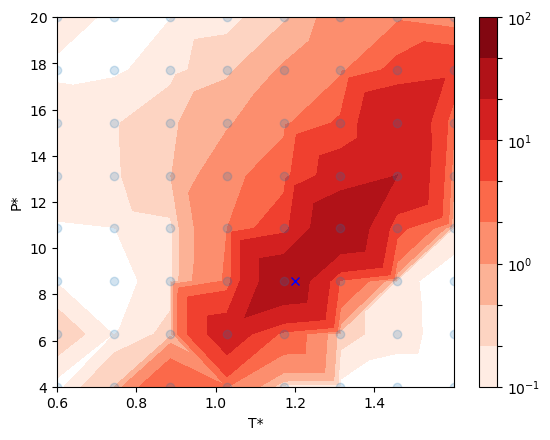

: 

In [44]:
contour = plt.tricontourf(
    evaluation_states[:, 0] / convert_from_reduced_t(EPSILON, KB),
    evaluation_states[:, 1] / convert_from_reduced_p(EPSILON, SIGMA),
    efficiencies * 100,
    norm=colors.LogNorm(),
    levels=np.geomspace(1e-1, 100, 10),
)
plt.colorbar(contour, ticks=np.geomspace(1e-1, 100, 10))
plt.scatter(
    evaluation_states[:, 0] / convert_from_reduced_t(EPSILON, KB),
    evaluation_states[:, 1] / convert_from_reduced_p(EPSILON, SIGMA),
    alpha=0.2,
)
plt.plot(REDUCED_TEMP_PRIOR, REDUCED_PRESS_PRIOR, "x", color="blue")
# plt.yscale('log')
plt.set_cmap("Reds")
plt.xlabel("T*")
plt.ylabel("P*")
plt.show()